In [243]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
import matplotlib.pyplot as plt


In [244]:
# Load dữ liệu
data = pd.read_csv('processed_data.csv')
data



,DateTime,nhiet_do,do_am,toc_do_gio,dong_buc_xa_chung,dong_buc_xa_tx,khu1,khu2,khu3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [245]:
# Chuyển đổi cột 'DateTime' thành kiểu datetime và đặt làm chỉ mục
data['DateTime'] = pd.to_datetime(data['DateTime'])
data = data.set_index('DateTime')

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52416 entries, 2017-01-01 00:00:00 to 2017-12-30 23:50:00
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nhiet_do           52416 non-null  float64
 1   do_am              52416 non-null  float64
 2   toc_do_gio         52416 non-null  float64
 3   dong_buc_xa_chung  52416 non-null  float64
 4   dong_buc_xa_tx     52416 non-null  float64
 5   khu1               52416 non-null  float64
 6   khu2               52416 non-null  float64
 7   khu3               52416 non-null  float64
dtypes: float64(8)
memory usage: 3.6 MB


In [246]:
data.head()

,nhiet_do,do_am,toc_do_gio,dong_buc_xa_chung,dong_buc_xa_tx,khu1,khu2,khu3
DateTime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [247]:
# Hàm tạo đặc trưng lag giữ lại DateTime
def create_lag_features_with_datetime(values, date_values, n_lags=10):
    X, y, dates = [], [], []
    for i in range(n_lags, len(values)):
        X.append(values[i-n_lags:i, 0])  # Sử dụng n_lags giá trị trước để tạo đặc trưng
        y.append(values[i, 0])          # Giá trị mục tiêu hiện tại
        dates.append(date_values[i])    # Lưu DateTime của giá trị hiện tại
    return np.array(X), np.array(y), np.array(dates)

# Chuẩn bị dữ liệu
n_lags = 10  # Số lượng bước lag
target_column = 'khu1'  # Cột cần dự đoán
values = data[[target_column]].values  # Lấy giá trị cột mục tiêu
date_values = data.index.to_numpy()  # Lấy mốc thời gian

# Gọi hàm để tạo đặc trưng lag
X, y, dates = create_lag_features_with_datetime(values, date_values, n_lags)


In [248]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, shuffle=False
)

# Kiểm tra dữ liệu
print("Dates for test set:")
print(dates_test[:10])  # Hiển thị 10 giá trị đầu tiên của DateTime trong tập kiểm tra


Dates for test set:
['2017-10-19T05:00:00.000000000' '2017-10-19T05:10:00.000000000'
 '2017-10-19T05:20:00.000000000' '2017-10-19T05:30:00.000000000'
 '2017-10-19T05:40:00.000000000' '2017-10-19T05:50:00.000000000'
 '2017-10-19T06:00:00.000000000' '2017-10-19T06:10:00.000000000'
 '2017-10-19T06:20:00.000000000' '2017-10-19T06:30:00.000000000']


In [249]:
y_test

array([26537.593  , 26928.3151 , 26758.16193, ..., 29590.87452,
       28958.1749 , 28349.80989])

In [250]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa dữ liệu đầu vào
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Chuẩn hóa dữ liệu mục tiêu
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


In [251]:
# Chuyển đổi y_train_scaled và y_test_scaled về dạng 1D
y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

print("y_train_scaled shape (sau khi chuyển):", y_train_scaled.shape)
print("y_test_scaled shape (sau khi chuyển):", y_test_scaled.shape)


y_train_scaled shape (sau khi chuyển): (41924,)
y_test_scaled shape (sau khi chuyển): (10482,)


In [281]:
X_test_scaled

(41924, 10)
(10482, 10)


In [253]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Xây dựng mô hình DNN
model = Sequential()

# Lớp đầu vào
model.add(Dense(64, input_dim=n_lags, activation='relu'))  # 64 nơ-ron, hàm kích hoạt relu

# Lớp ẩn
model.add(Dense(32, activation='relu'))  # 32 nơ-ron, hàm kích hoạt relu
model.add(Dropout(0.2))  # Dropout để giảm overfitting (20%)

# Lớp đầu ra
model.add(Dense(1))  # Dự đoán giá trị liên tục (không dùng activation)

# Xem tóm tắt mô hình
model.summary()
from tensorflow.keras.optimizers import Adam

# Biên dịch mô hình
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Tối ưu hóa Adam với learning rate = 0.001
    loss='mse',                           # Hàm mất mát Mean Squared Error
    metrics=['mae']                       # Đánh giá bằng Mean Absolute Error
)


D:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

In [254]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0115 - mae: 0.0751 - val_loss: 3.5172e-04 - val_mae: 0.0122
Epoch 2/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - loss: 0.0020 - mae: 0.0310 - val_loss: 3.1036e-04 - val_mae: 0.0138
Epoch 3/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - loss: 0.0013 - mae: 0.0256 - val_loss: 2.4082e-04 - val_mae: 0.0113
Epoch 4/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - loss: 0.0012 - mae: 0.0249 - val_loss: 3.8534e-04 - val_mae: 0.0169
Epoch 5/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - loss: 0.0012 - mae: 0.0247 - val_loss: 2.2075e-04 - val_mae: 0.0113
Epoch 6/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - loss: 0.0012 - mae: 0.0244 - val_loss: 1.4040e-04 - val_mae: 0.0077
Epoch 7/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0011 - mae: 0.0236 - val_loss: 1.9520e-04 - val_mae: 0.0107
Epoch 8/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - loss: 0.0011 - mae: 0.0235 - val_loss: 2.3290e-04 - val_mae: 0.0

In [255]:
y_actual_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [285]:
# Dự báo trên tập kiểm tra
y_pred = model.predict(X_test_scaled)

# Tạo DataFrame với DateTime, Actual và Predicted
results = pd.DataFrame({
    'DateTime': dates_test,   # DateTime tương ứng với tập kiểm tra
    'Actual': y_test_scaled.flatten(),  # Giá trị thực tế
    'Predicted': y_pred.flatten()  # Giá trị dự đoán
})

# Hiển thị 10 dòng đầu tiên
print("Dữ liệu thực tế và dự đoán:")
print(results.head(10))


328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
Dự đoán của mô hình: [[0.31305355]
 [0.34223217]
 [0.35153472]
 [0.34105045]
 [0.3394906 ]
 [0.35062698]
 [0.34055907]
 [0.32817426]
 [0.3078001 ]
 [0.30732894]]


ValueError: Expected 2D array, got 1D array instead:
array=[0.33000068 0.34019999 0.33575835 ... 0.40970272 0.3931869  0.37730631].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

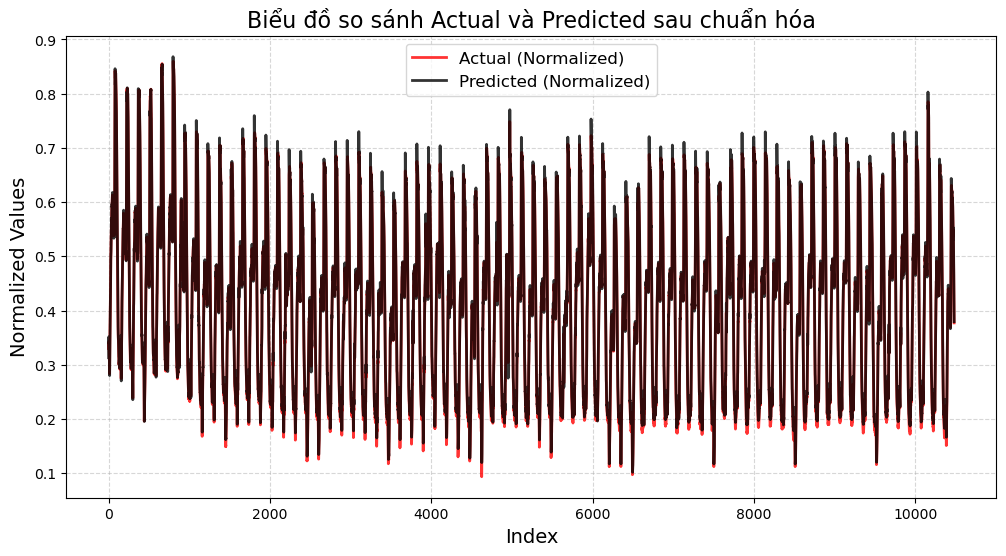

In [257]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Actual và Predicted với màu sắc tùy chỉnh
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Actual'], label='Actual (Normalized)', color='red', linewidth=2, alpha=0.8)  # Đường đỏ
plt.plot(results.index, results['Predicted'], label='Predicted (Normalized)', color='black', linewidth=2, alpha=0.8)  # Đường đen
plt.title('Biểu đồ so sánh Actual và Predicted sau chuẩn hóa', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Normalized Values', fontsize=14)
plt.legend(fontsize=12)  # Tăng kích thước chú thích
plt.grid(True, linestyle='--', alpha=0.5)  # Thêm lưới để dễ đọc
plt.show()
